In [247]:
import tensorflow as tf
import numpy as np
import json
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageOps
import re
import numpy as np

# Function to resize labels
def resize_labels(labels, original_size, new_size):
    # Adjust the label coordinates for the new image size
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]

    
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels


# Function to convert labels to EfficientDet format
def convert_to_efficientdet_format(labels, image_shape):
    efficientdet_labels = []
    for label in labels:
        # Calculate the coordinates of the upper left and lower right corners
        xmin = (label['x'] - label['radius']) / image_shape[1]
        ymin = (label['y'] - label['radius']) / image_shape[0]
        xmax = (label['x'] + label['radius']) / image_shape[1]
        ymax = (label['y'] + label['radius']) / image_shape[0]
        # EfficientDet format [ymin, xmin, ymax, xmax]
        efficientdet_labels.append([
            max(0, ymin), max(0, xmin), min(1, ymax), min(1, xmax)
        ])
    return efficientdet_labels

def numerical_sort(file):
    """Extracts numbers from filename for sorting."""
    numbers = re.findall(r'\d+', file)
    return int(numbers[0]) if numbers else 0

# Function to load images and labels
def load_images_and_labels(image_dir, label_dir, original_size=(1024, 1024), new_size=(512, 512)):
    image_files = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir), key=numerical_sort) if file.endswith('.png')]
    
    images = []
    all_boxes = []
    all_masks = []  # List to hold mask labels

    for image_file in image_files:
        label_file_name = os.path.splitext(os.path.basename(image_file))[0] + '.json'
        label_file_path = os.path.join(label_dir, label_file_name)

        if not os.path.exists(label_file_path):
            # print(f"Warning: Label file {label_file_path} not found for image {image_file}. Skipping.")
            continue

        # Load and resize image
        image = load_img(image_file, color_mode='rgb')
        
        image = pad_or_crop_image(image, new_size[0], new_size[1])

        image = (img_to_array(image) / 127.5) - 1  # Convert to array and scale pixel values
        images.append(image)

        # Load labels and adjust for new image size
        with open(label_file_path, 'r') as file:
            json_data = json.load(file)
        
        resized_json_data = resize_labels(json_data, original_size=original_size, new_size=new_size)
        
        boxes = convert_to_efficientdet_format(resized_json_data, new_size)
        all_boxes.append(boxes)
        
        # Store the resized labels for mask plotting
        mask_labels = [{'x': label['x'], 'y': label['y'], 'radius': label['radius']} for label in resized_json_data]
        all_masks.append(mask_labels)
    
    return np.array(images), all_boxes, all_masks


# Function to pad labels to a fixed size
def pad_labels(labels, max_boxes=250, pad_value=0):
    padded_labels = []
    for label in labels:
        padded_label = np.zeros((max_boxes, 4), dtype=np.float32) + pad_value
        num_boxes = min(len(label), max_boxes)
        padded_label[:num_boxes] = label[:num_boxes]
        padded_labels.append(padded_label)
    return np.array(padded_labels)

# Function to prepare the dataset
def prepare_dataset(images, boxes, batch_size, num_boxes=250):
    images = tf.constant(images, dtype=tf.float32)
    boxes = pad_labels(boxes, max_boxes=num_boxes)
    boxes = tf.constant(boxes, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((images, boxes))
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



def pad_or_crop_image(image, desired_width, desired_height):
    """
    Pad or crop the given image to the desired width and height, with padding
    applied only to the right and bottom sides. Padding is applied with a value of 255 (white).

    Parameters:
    - image: PngImageFile, the input image to be processed.
    - desired_width: int, the desired width of the output image.
    - desired_height: int, the desired height of the output image.

    Returns:
    - PngImageFile, the processed image with the desired dimensions.
    """
    # Calculate the differences between desired dimensions and current dimensions
    delta_width = desired_width - image.width
    delta_height = desired_height - image.height
    
    # Determine padding amounts for each side, ensuring they are non-negative
    pad_width = max(delta_width, 0)
    pad_height = max(delta_height, 0)
    
    # Apply padding only to the right and bottom sides
    padding = (0, 0, pad_width, pad_height)  # Left, Top, Right, Bottom
    
    # Pad the image if necessary
    if pad_width > 0 or pad_height > 0:
        image = ImageOps.expand(image, padding, fill=0)
    else:
        # If padding is not needed, check if we need to crop
        if delta_width < 0 or delta_height < 0:
            # Crop the image without changing the starting top left corner (0, 0)
            right = image.width + delta_width if delta_width < 0 else image.width
            bottom = image.height + delta_height if delta_height < 0 else image.height
            
            # Crop the image
            image = image.crop((0, 0, right, bottom))
    
    return image

    

def plot_image_with_labels(image, labels, mode='boxes', opacity=0.2, figsize=(10, 10)):
    """
    Plots an image with either overlaid bounding boxes or masks based on labels.
    
    Args:
    - image: The image as a NumPy array.
    - labels: A list of labels. Each label should be a dict with 'x', 'y', and 'radius' for masks,
              or a NumPy array of bounding boxes for boxes.
    - mode: 'boxes' to draw bounding boxes, 'masks' to overlay masks.
    - opacity: The opacity of the masks, if masks are to be drawn.
    - figsize: The size of the figure to display.
    """

    fig, ax = plt.subplots(1, figsize=figsize)

    ax.imshow(image)
    
    if mode == 'boxes':
        img_height, img_width = image.shape[:2]
        for box in labels:
            if np.all(box == 0):
                continue  # Skip boxes that are all zeros
            ymin, xmin, ymax, xmax = box
            rect = patches.Rectangle((xmin * img_width, ymin * img_height), 
                                     (xmax - xmin) * img_width, (ymax - ymin) * img_height,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    elif mode == 'masks':
        for label in labels:
            # Use disk to create a mask
            # Draw a circle for each label
            circle = Circle((label['x'], label['y']), label['radius'], color='red', fill=True, alpha=opacity, edgecolor='red', linestyle='-', linewidth=2)
            ax.add_patch(circle)

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_59314/445919344.py:189: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((label['x'], label['y']), label['radius'], color='red', fill=True, alpha=opacity, edgecolor='red', linestyle='-', linewidth=2)


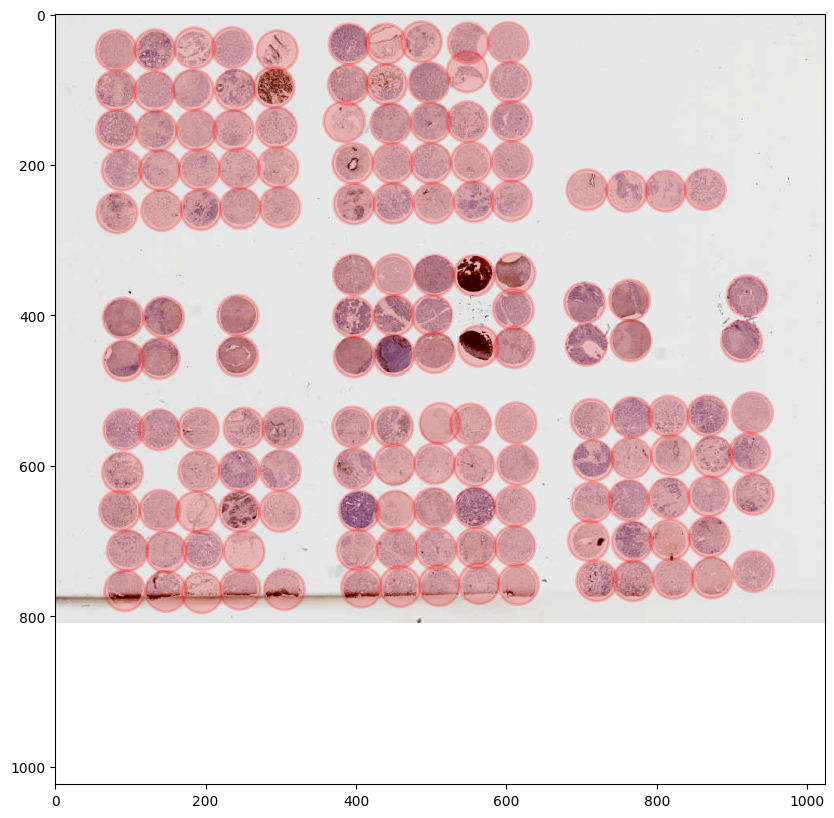

In [322]:
image_dir = './TMA_WSI_Padded_PNGs'
label_dir = './TMA_WSI_Labels_updated'

# image_dir = './image_labels'
# label_dir = './TMA_WSI_Labels_updated'

images, boxes, masks = load_images_and_labels(image_dir, label_dir, original_size=(1024, 1024), new_size=(1024, 1024))
# Map this preprocessing function to your dataset



image_number = 5
# Example usage:
# Assuming `images` is your array of images loaded from the dataset and
# `boxes` is the array of bounding boxes for the corresponding images.
# Here we visualize the first image and its boxes.
plot_image_with_labels(images[image_number], masks[image_number], "masks")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_59314/445919344.py:189: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((label['x'], label['y']), label['radius'], color='red', fill=True, alpha=opacity, edgecolor='red', linestyle='-', linewidth=2)


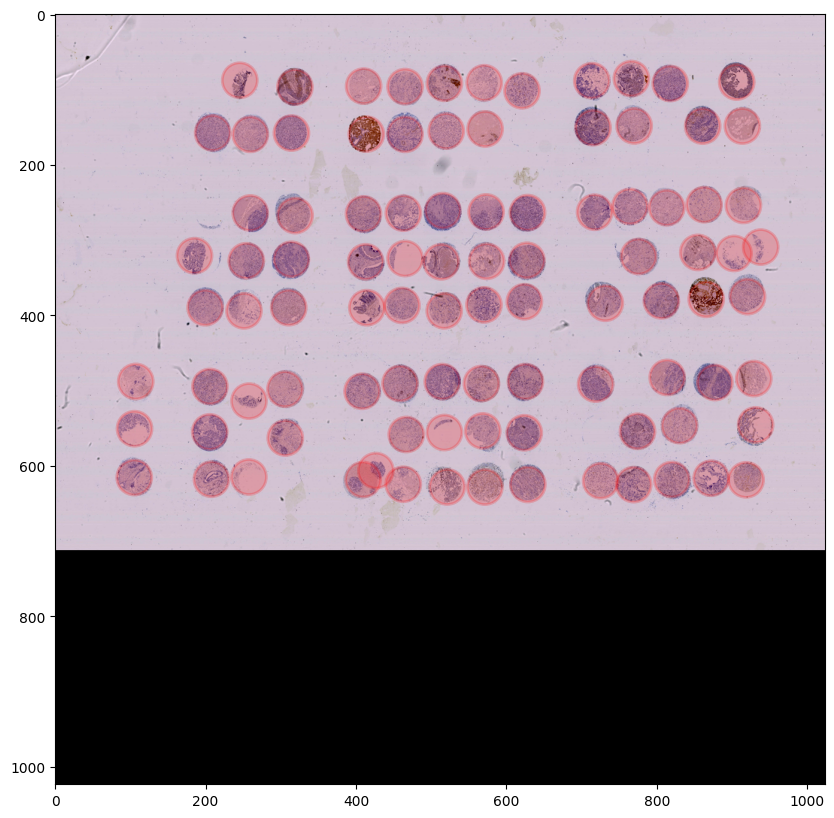

In [319]:
image_dir = '../TMA_WSI_PNGs'
label_dir = '../TMA_WSI_Labels'

# image_dir = './image_labels'
# label_dir = './TMA_WSI_Labels_updated'

images, boxes, masks = load_images_and_labels(image_dir, label_dir, original_size=(1024, 1024), new_size=(1024, 1024))
# Map this preprocessing function to your dataset

image_number = 33
# Example usage:
# Assuming `images` is your array of images loaded from the dataset and
# `boxes` is the array of bounding boxes for the corresponding images.
# Here we visualize the first image and its boxes.
plot_image_with_labels(images[image_number], masks[image_number], "masks")
